<a href="https://colab.research.google.com/github/seanzhu815/business-forecasting/blob/main/405assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [1]:
! pip install pymc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as skSFS
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score,mean_squared_error
import warnings
import seaborn as sns
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
import scipy as scp
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

Mounted at /content/drive/


#Part1

## 1

In [3]:
df = pd.read_excel("drive/MyDrive/MGTF405/US_House_index.xlsx",parse_dates=True,index_col=0)

In [4]:
df['DHP']=np.log(df['HousePI']).diff()
df['CPIL']=df['CPI'].shift(1)
df['MORT30L']=df['MORT30'].shift(1)
df['UnitsL']=df['Units'].shift(1)
df['UNRATEL']=df['UNRATE'].shift(1)

In [5]:
df

,HousePI,CPI,MORT30,UNRATE,Units,DHP,CPIL,MORT30L,UnitsL,UNRATEL
date,,,,,,,,,,
1987-01-01,63.734,111.400,9.2040,6.6,1090,NaN,NaN,NaN,NaN,NaN
1987-02-01,64.134,111.800,9.0825,6.6,1096,0.006256,111.400,9.2040,1090.0,6.6
1987-03-01,64.470,112.200,9.0350,6.6,1084,0.005225,111.800,9.0825,1096.0,6.6
1987-04-01,64.974,112.700,9.8325,6.3,1079,0.007787,112.200,9.0350,1084.0,6.6
1987-05-01,65.548,113.000,10.5960,6.3,1070,0.008796,112.700,9.8325,1079.0,6.3
...,...,...,...,...,...,...,...,...,...,...
2022-03-01,295.054,287.708,4.1720,3.6,1629,0.026705,284.182,3.7625,1582.0,3.8
2022-04-01,301.655,288.663,4.9825,3.6,1668,0.022126,287.708,4.1720,1629.0,3.6
2022-05-01,306.639,291.474,5.2300,3.6,1677,0.016387,288.663,4.9825,1668.0,3.6


In [6]:
df['Infl'] = np.log(df['CPI']).diff()

In [7]:
df['DUnits']=np.log(df['Units']).diff()

In [8]:
df=df.iloc[1:,]

In [9]:
def adf_test(timeseries, reg):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, regression=reg, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [10]:
adf_test(df['DHP'], 'c'),adf_test(df['HousePI'], 'c') 

Results of Dickey-Fuller Test:
Test Statistic                  -3.758874
p-value                          0.003357
#Lags Used                      17.000000
Number of Observations Used    408.000000
Critical Value (1%)             -3.446480
Critical Value (5%)             -2.868650
Critical Value (10%)            -2.570557
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   0.907594
p-value                          0.993189
#Lags Used                      18.000000
Number of Observations Used    407.000000
Critical Value (1%)             -3.446520
Critical Value (5%)             -2.868668
Critical Value (10%)            -2.570567
dtype: float64


(None, None)

In [11]:
df

,HousePI,CPI,MORT30,UNRATE,Units,DHP,CPIL,MORT30L,UnitsL,UNRATEL,Infl,DUnits
date,,,,,,,,,,,,
1987-02-01,64.134,111.800,9.0825,6.6,1096,0.006256,111.400,9.2040,1090.0,6.6,0.003584,0.005489
1987-03-01,64.470,112.200,9.0350,6.6,1084,0.005225,111.800,9.0825,1096.0,6.6,0.003571,-0.011009
1987-04-01,64.974,112.700,9.8325,6.3,1079,0.007787,112.200,9.0350,1084.0,6.6,0.004446,-0.004623
1987-05-01,65.548,113.000,10.5960,6.3,1070,0.008796,112.700,9.8325,1079.0,6.3,0.002658,-0.008376
1987-06-01,66.219,113.500,10.5375,6.2,1060,0.010185,113.000,10.5960,1070.0,6.3,0.004415,-0.009390
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,295.054,287.708,4.1720,3.6,1629,0.026705,284.182,3.7625,1582.0,3.8,0.012331,0.029276
2022-04-01,301.655,288.663,4.9825,3.6,1668,0.022126,287.708,4.1720,1629.0,3.6,0.003314,0.023659
2022-05-01,306.639,291.474,5.2300,3.6,1677,0.016387,288.663,4.9825,1668.0,3.6,0.009691,0.005381


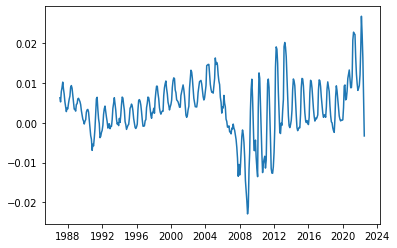

In [12]:
plt.plot(df['DHP'])

In [13]:
def AIC_PDQ(df,ar,ii,ma): 
# Define the p, d and q parameters to take any user defined value. We need to be careful with integration order, cannot be 0.    p = range(0,ar)
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        try:
            mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
          
            output = mod.fit()
            ans.append([comb, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    return ans_df

In [14]:
AIC_hp = AIC_PDQ(df['DHP'],6,1,3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

In [15]:
minIndices = max(AIC_hp.apply(lambda x:(np.argmin(x)),0))
print(f'The order for best AIC = {AIC_hp.iloc[minIndices,0]} for Inflation ')

The order for best AIC = (2, 0, 0) for Inflation 


In [16]:
mod = ARIMA(df['DHP'], order=(2,0,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [17]:
res=mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    DHP   No. Observations:                  426
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1987.291
Date:                Sat, 05 Nov 2022   AIC                          -3966.581
Time:                        19:35:52   BIC                          -3950.363
Sample:                    02-01-1987   HQIC                         -3960.175
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.409      0.000       0.002       0.005
ar.L1          1.4822      0.028     53.359      0.000       1.428       1.537
ar.L2         -0.6359      0.030    -20.956      0.000      -0.695      -0.576
sigma2      5.145e-06   1.76e-07     29.220      0.000     4.8e-06    5.49e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1454.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.77   Skew:                             1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


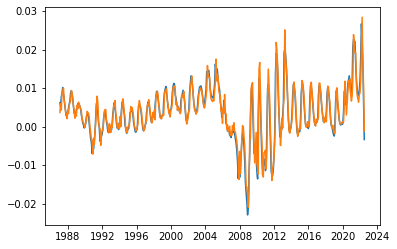

In [18]:
df['DHP_fit'] = res.predict()
plt.plot(df['DHP'])
plt.plot(df['DHP_fit'])

In [19]:
def MSE(actual, pred):
    sse = [(a-p)**2 for a,p in zip(actual,pred)]
    return(np.mean(sse))

In [20]:
MSE(df['DHP'], df['DHP_fit'])

5.1755053074337585e-06

In [21]:
alpha=res.params[0]
beta=res.params[1]

In [22]:
sigma=df['DHP']-(beta*df['DHP_fit'])-alpha

In [23]:
IR=alpha/sigma.std()
IR=IR.mean()
IR

0.9555107659526351

## 2

In [24]:
df

,HousePI,CPI,MORT30,UNRATE,Units,DHP,CPIL,MORT30L,UnitsL,UNRATEL,Infl,DUnits,DHP_fit
date,,,,,,,,,,,,,
1987-02-01,64.134,111.800,9.0825,6.6,1096,0.006256,111.400,9.2040,1090.0,6.6,0.003584,0.005489,0.003693
1987-03-01,64.470,112.200,9.0350,6.6,1084,0.005225,111.800,9.0825,1096.0,6.6,0.003571,-0.011009,0.006016
1987-04-01,64.974,112.700,9.8325,6.3,1079,0.007787,112.200,9.0350,1084.0,6.6,0.004446,-0.004623,0.004334
1987-05-01,65.548,113.000,10.5960,6.3,1070,0.008796,112.700,9.8325,1079.0,6.3,0.002658,-0.008376,0.008787
1987-06-01,66.219,113.500,10.5375,6.2,1060,0.010185,113.000,10.5960,1070.0,6.3,0.004415,-0.009390,0.008652
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,295.054,287.708,4.1720,3.6,1629,0.026705,284.182,3.7625,1582.0,3.8,0.012331,0.029276,0.020295
2022-04-01,301.655,288.663,4.9825,3.6,1668,0.022126,287.708,4.1720,1629.0,3.6,0.003314,0.023659,0.028414
2022-05-01,306.639,291.474,5.2300,3.6,1677,0.016387,288.663,4.9825,1668.0,3.6,0.009691,0.005381,0.016381


In [25]:
adf_test(df['CPIL'], 'c')
adf_test(df['MORT30L'], 'c') 
adf_test(df['UnitsL'], 'c') 
adf_test(df['UNRATEL'], 'c') 

Results of Dickey-Fuller Test:
Test Statistic                   1.687365
p-value                          0.998097
#Lags Used                      15.000000
Number of Observations Used    410.000000
Critical Value (1%)             -3.446401
Critical Value (5%)             -2.868615
Critical Value (10%)            -2.570539
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -1.852953
p-value                          0.354507
#Lags Used                       3.000000
Number of Observations Used    422.000000
Critical Value (1%)             -3.445941
Critical Value (5%)             -2.868413
Critical Value (10%)            -2.570431
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -1.852717
p-value                          0.354620
#Lags Used                      17.000000
Number of Observations Used    408.000000
Critical Value (1%)             -3.446480
Critical Value (5%)             -2.868650
Critical Value (10%)            -2.57

In [26]:
df['DMORT']=np.log(df['MORT30']).diff()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
df=df.dropna()

In [28]:
adf_test(df['Infl'], 'c')
adf_test(df['DMORT'], 'c') 
adf_test(df['DUnits'].diff(1).dropna(), 'c') 

Results of Dickey-Fuller Test:
Test Statistic                  -2.860463
p-value                          0.050143
#Lags Used                      14.000000
Number of Observations Used    410.000000
Critical Value (1%)             -3.446401
Critical Value (5%)             -2.868615
Critical Value (10%)            -2.570539
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.879695e+00
p-value                        3.798976e-17
#Lags Used                     2.000000e+00
Number of Observations Used    4.220000e+02
Critical Value (1%)           -3.445941e+00
Critical Value (5%)           -2.868413e+00
Critical Value (10%)          -2.570431e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.415642e+00
p-value                        6.947291e-11
#Lags Used                     1.200000e+01
Number of Observations Used    4.110000e+02
Critical Value (1%)           -3.446361e+00
Critical Value (5%)           -2.868598e+00
Critical Va

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

5.178571714504692e-06

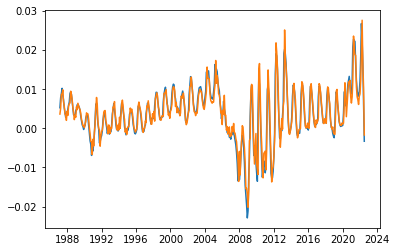

In [29]:
mod1 = ARIMA(df['DHP'],exog=df['Infl'], order=(2,0,0))
res1=mod1.fit()
res1.summary()
df['CPIL_fit'] = res1.predict()
plt.plot(df['DHP'])
plt.plot(df['CPIL_fit'])
MSE(df['DHP'], df['CPIL_fit'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


5.439231229916459e-06

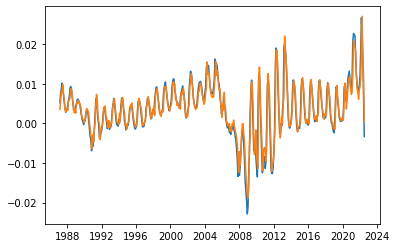

In [30]:
mod2 = ARIMA(df['DHP'],exog=df['DMORT'], order=(2,0,0))
res2=mod2.fit()
res2.summary()
df['MORT30_fit'] = res2.predict()
plt.plot(df['DHP'])
plt.plot(df['MORT30_fit'])
MSE(df['DHP'], df['MORT30_fit'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


5.15831900509388e-06

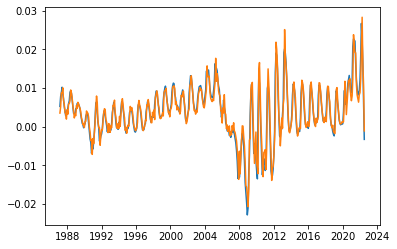

In [31]:
mod2 = ARIMA(df['DHP'],exog=df['DUnits'], order=(2,0,0))
res2=mod2.fit()
res2.summary()
df['UnitsL_fit'] = res2.predict()
plt.plot(df['DHP'])
plt.plot(df['UnitsL_fit'])
MSE(df['DHP'], df['UnitsL_fit'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


5.117768819192179e-06

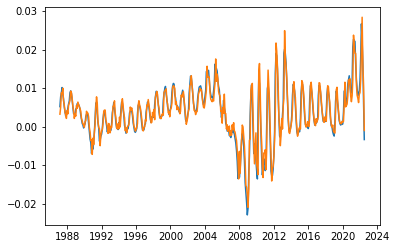

In [32]:
mod2 = ARIMA(df['DHP'],exog=df['UNRATEL'], order=(2,0,0))
res2=mod2.fit()
res2.summary()
df['UNRATEL_fit'] = res2.predict()
plt.plot(df['DHP'])
plt.plot(df['UNRATEL_fit'])
MSE(df['DHP'], df['UNRATEL_fit'])

# 3

In [33]:
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [34]:
df

,HousePI,CPI,MORT30,UNRATE,Units,DHP,CPIL,MORT30L,UnitsL,UNRATEL,Infl,DUnits,DHP_fit,DMORT,CPIL_fit,MORT30_fit,UnitsL_fit,UNRATEL_fit
date,,,,,,,,,,,,,,,,,,
1987-03-01,64.470,112.200,9.0350,6.6,1084,0.005225,111.800,9.0825,1096.0,6.6,0.003571,-0.011009,0.006016,-0.005244,0.003618,0.003554,0.003492,0.003268
1987-04-01,64.974,112.700,9.8325,6.3,1079,0.007787,112.200,9.0350,1084.0,6.6,0.004446,-0.004623,0.004334,0.084587,0.005083,0.005722,0.005093,0.005035
1987-05-01,65.548,113.000,10.5960,6.3,1070,0.008796,112.700,9.8325,1079.0,6.3,0.002658,-0.008376,0.008787,0.074783,0.008620,0.007931,0.008710,0.008810
1987-06-01,66.219,113.500,10.5375,6.2,1060,0.010185,113.000,10.5960,1070.0,6.3,0.004415,-0.009390,0.008652,-0.005536,0.008623,0.007863,0.008618,0.008503
1987-07-01,66.787,113.800,10.2780,6.1,1051,0.008541,113.500,10.5375,1060.0,6.2,0.002640,-0.008527,0.010070,-0.024935,0.009811,0.009789,0.010033,0.010021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,295.054,287.708,4.1720,3.6,1629,0.026705,284.182,3.7625,1582.0,3.8,0.012331,0.029276,0.020295,0.103312,0.020137,0.019063,0.020306,0.020402
2022-04-01,301.655,288.663,4.9825,3.6,1668,0.022126,287.708,4.1720,1629.0,3.6,0.003314,0.023659,0.028414,0.177536,0.027545,0.027056,0.028295,0.028416
2022-05-01,306.639,291.474,5.2300,3.6,1677,0.016387,288.663,4.9825,1668.0,3.6,0.009691,0.005381,0.016381,0.048480,0.016300,0.015919,0.016260,0.016327


In [35]:
model_data = df[['DHP','Infl','MORT30','UNRATE','DUnits']]
train_data= model_data.iloc[:-20,:]
test_data = model_data.iloc[-20:,:]

In [36]:
test_data

,DHP,Infl,MORT30,UNRATE,DUnits
date,,,,,
2020-12-01,0.008779,0.003228,2.6840,6.7,0.010363
2021-01-01,0.008817,0.002429,2.7350,6.4,0.016516
2021-02-01,0.011636,0.004361,2.8100,6.2,0.004669
2021-03-01,0.020714,0.006367,3.0825,6.0,0.013878
2021-04-01,0.022714,0.006390,3.0600,6.0,0.012177
2021-05-01,0.022284,0.006994,2.9625,5.8,0.012777
2021-06-01,0.022154,0.008733,2.9750,5.9,0.024346
2021-07-01,0.016439,0.004526,2.8680,5.4,0.010152
2021-08-01,0.012245,0.003330,2.8425,5.2,0.019293


In [ ]:
VARmodel1 = VAR(train_data).fit(maxlags=1, ic='aic')

VARmodel1.summary()

In [ ]:
VARmodel2 = VAR(train_data).fit(maxlags=2, ic='aic')

VARmodel2.summary()

## 4

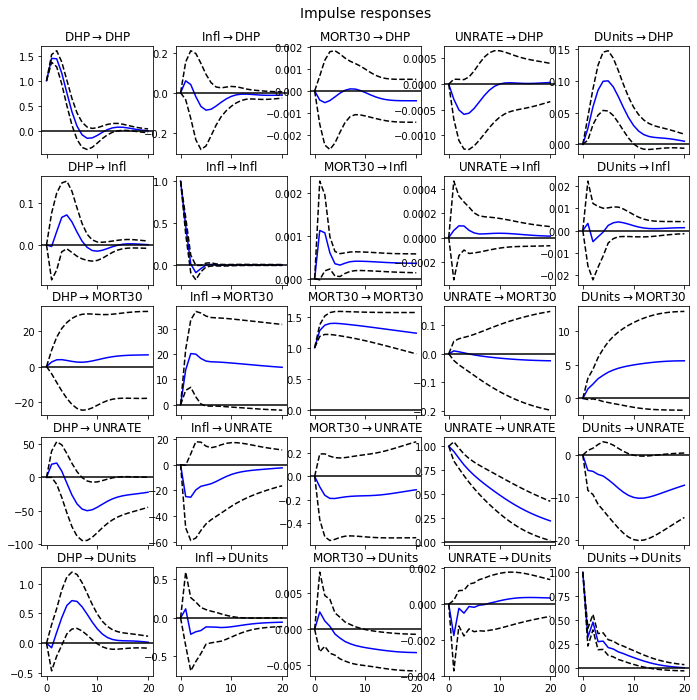

In [42]:
num_periods = 20
ir = VARmodel2.irf(periods=num_periods)
ir.plot(plot_stderr=True)
plt.show()

## 5

In [62]:
df

,HousePI,CPI,MORT30,UNRATE,Units,DHP,CPIL,MORT30L,UnitsL,UNRATEL,Infl,DUnits,DHP_fit,DMORT,CPIL_fit,MORT30_fit,UnitsL_fit,UNRATEL_fit
date,,,,,,,,,,,,,,,,,,
1987-03-01,64.470,112.200,9.0350,6.6,1084,0.005225,111.800,9.0825,1096.0,6.6,0.003571,-0.011009,0.006016,-0.005244,0.003618,0.003554,0.003492,0.003268
1987-04-01,64.974,112.700,9.8325,6.3,1079,0.007787,112.200,9.0350,1084.0,6.6,0.004446,-0.004623,0.004334,0.084587,0.005083,0.005722,0.005093,0.005035
1987-05-01,65.548,113.000,10.5960,6.3,1070,0.008796,112.700,9.8325,1079.0,6.3,0.002658,-0.008376,0.008787,0.074783,0.008620,0.007931,0.008710,0.008810
1987-06-01,66.219,113.500,10.5375,6.2,1060,0.010185,113.000,10.5960,1070.0,6.3,0.004415,-0.009390,0.008652,-0.005536,0.008623,0.007863,0.008618,0.008503
1987-07-01,66.787,113.800,10.2780,6.1,1051,0.008541,113.500,10.5375,1060.0,6.2,0.002640,-0.008527,0.010070,-0.024935,0.009811,0.009789,0.010033,0.010021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,295.054,287.708,4.1720,3.6,1629,0.026705,284.182,3.7625,1582.0,3.8,0.012331,0.029276,0.020295,0.103312,0.020137,0.019063,0.020306,0.020402
2022-04-01,301.655,288.663,4.9825,3.6,1668,0.022126,287.708,4.1720,1629.0,3.6,0.003314,0.023659,0.028414,0.177536,0.027545,0.027056,0.028295,0.028416
2022-05-01,306.639,291.474,5.2300,3.6,1677,0.016387,288.663,4.9825,1668.0,3.6,0.009691,0.005381,0.016381,0.048480,0.016300,0.015919,0.016260,0.016327


In [54]:
lagged_Values = model_data.values
pred =VARmodel2.forecast(y=lagged_Values, steps=17) 

In [55]:
idx = pd.date_range('2022-08-01', periods=17, freq='MS')
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['DHP','Infl','MORT30','UNRATE','DUnits'])

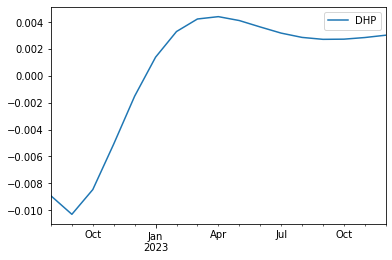

In [56]:
df_forecast['DHP'].plot(legend=True)

In [61]:
df_forecast.iloc[5:,0].sum()

0.0384103492933183